In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append("../") # <-- Path to the DRL4AMM repo

from DRL4AMM.gym.AvellanedaStoikovEnvironment import AvellanedaStoikovEnvironment
from DRL4AMM.rewards.RewardFunctions import PnL, CJ_criterion

from DRL4AMM.tile_coding.tile_coding import *

In [2]:
terminal_time = 1.0
n_steps = 100
arrival_rate = 50.0
reward_function = CJ_criterion()
timestamps = np.linspace(0, terminal_time, n_steps + 1)
env_params = dict(terminal_time=terminal_time, n_steps=n_steps, arrival_rate=arrival_rate, reward_function=reward_function)
env = AvellanedaStoikovEnvironment(**env_params)

In [3]:
#print("Action Space {}".format(env.action_space))
#print("State Space {}".format(env.observation_space))

In [4]:
# First create our tilings

feature_ranges = [[lb,ub] for lb,ub in zip(list(env.observation_space.low), list(env.observation_space.high))]  
number_tilings = 1
n_bins = 5
bins = [[n_bins] * 10]  
offsets = [[0, 0, 0, 0]]
tilings = create_tilings(feature_ranges, number_tilings, bins, offsets)
print(tilings.shape)  # # of tilings X features X bins

(1, 4, 4)


In [5]:
# First create our tilings

#feature_ranges = [[lb,ub] for lb,ub in zip(list(env.observation_space.low), list(env.observation_space.high))]  
#number_tilings = 3
#bins = [[10, 10, 10, 10], [10, 10, 10, 10], [10, 10, 10, 10]]  # each tiling has a 10*10*10*10 grid
#offsets = [[0, 0, 0, 0], [10, 1000, 10, 0.1], [20, 2000, 20, 0.2]]
#tilings = create_tilings(feature_ranges, number_tilings, bins, offsets)
#print(tilings.shape)  # # of tilings X features X bins

In [6]:
def get_action_space():
        
    from itertools import product

    base1 = np.arange(0,1,0.1)
    base2 = np.arange(0,1,0.1)
    action_space = np.array(list(product(*[base1, base2])),dtype='float32')
    action_space = list(action_space)
    
    return [tuple(a) for a in action_space]

In [7]:
action_space = get_action_space()
q = QValueFunction(tilings, action_space, lr = 0.01, gamma = 0.99, eps = 0.01)

In [8]:
from tqdm import tqdm

N_STEPS = 10000

new_state = list(env.reset())

# arbitrary first action
action = action_space[0]

keep_rewards = []
keep_actions = []
keep_episodic_rewards = []

episodic_reward = 0

for i in tqdm(range(N_STEPS)):
    
    # take the new action
    new = env.step(action)
    
    # new state and collected reward
    old_state = new_state
    new_state = list(new[0])
    reward = new[1]
    done = new[2]

    # increment episodic reward
    episodic_reward += reward
    
    if done:
        keep_episodic_rewards.append(episodic_reward)
        #print("Episodic reward", episodic_reward)
        
        # reset episodic reward
        episodic_reward = 0
        new_state = list(env.reset())
    
    else:
    
        # create Q target
        target = q.get_target(reward, new_state)
    
        # perform Q update
        q.update(old_state, action, target)
    
        # select new action based on new state
        action = q.eps_greedy(new_state)
    
            
    # keep reward and action
    keep_rewards.append(reward)
    keep_actions.append(action)
    
    #if i % 100 == 0:    
    #    rewards = pd.Series(keep_rewards)
    #    print(rewards.rolling(100).mean().tail(1))

100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [01:52<00:00, 88.59it/s]


<AxesSubplot:>

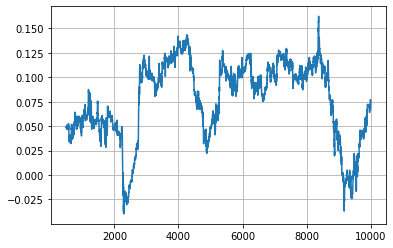

In [9]:
rewards = pd.Series(keep_rewards)
rewards.rolling(500).mean().plot(grid=True)

array([[<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

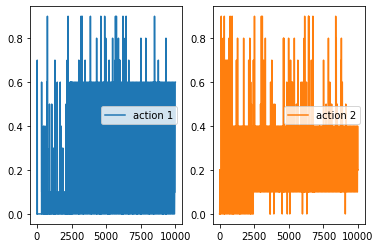

In [10]:
actions_df = pd.DataFrame(keep_actions)
actions_df.columns = ['action 1', 'action 2']
actions_df.plot(subplots=True, layout=(1,2))

<AxesSubplot:>

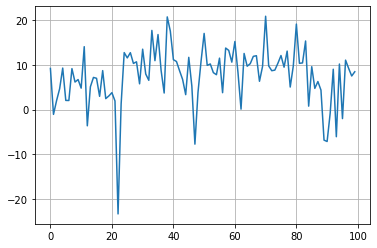

In [11]:
episodic_rewards = pd.Series(keep_episodic_rewards)
episodic_rewards.plot(grid=True)